In [8]:
import math
import json
import os
import sys
import pdb
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
#import seaborn as sn
#import scipy.stats
from scipy import stats
import scipy.stats
import scipy.optimize

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import * # download_link, lipids_dict, databank

In [9]:
path = '../Data/Flipflops/'
db_data = databank(path)
systems = db_data.get_systems()

Databank initialized from the folder: /home/sosamuli/work/NMRlipids/DataBankManuscript/Data/Flipflops


In [11]:
def getFlipflop(path):
    try:
        f = open(f'{path}flipflop.dat', 'r')
    except:
        print("no file")
        return np.array([]) #, [], []
        
    lines = f.readlines()[1:]
    flipflops = [line.split('    ') for line in lines]
    #names = [line[0] for line in flipflops]
    #flipflops = [line[1:] for line in flipflops]
    #list_names = list(set(names))
    
    if len(flipflops) == 0:
        flipflops = np.array(flipflops)
        flipflops = flipflops.astype('int64')
        return flipflops #, [], []
    
    for flip in flipflops:
        if flip[-1] == 'Success\n':
            flip[-1] = '1'
        else:
            flip[-1] = '0'
        #flip[0] = dict_names[flip[0]]
        
    flipflops = np.array(flipflops)
    #flipflops = flipflops.astype('int64')
    #print(flipflops)
    return flipflops #, names, list_names

def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty]['success'])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def plotXaveragedData(xProperty,yProperty,permeationResults,rounddec,MinimumDataLength):
    avetemp = {}
    for ID in permeationResults:
        #print(permeationVStemperature[ID])
        temperature = rounddec * round(permeationResults[ID][xProperty] / rounddec)
        if temperature not in avetemp.keys():
            avetemp[temperature] = {}
            avetemp[temperature]['values'] = []
            avetemp[temperature]['weigths'] = []
        avetemp[temperature]['values'].append(permeationResults[ID][yProperty]['success'])
        avetemp[temperature]['weigths'].append(permeationResults[ID]['SimLength']) 
        #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
    xPropertyData = []
    yPropertyData = []
    yPropertyDataError = []
    for temp in avetemp:
        #if len(avetemp[temp]['values']) < 3:
        #    continue
        if np.sum(avetemp[temp]['weigths']) < MinimumDataLength:
            continue
        average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
        variance = np.average((avetemp[temp]['values']-average)**2, weights = avetemp[temp]['weigths'])
        xPropertyData.append(temp)
        yPropertyData.append(average)
        yPropertyDataError.append(math.sqrt(variance)/math.sqrt(len(avetemp[temp]['values'])))
        #yPropertyDataError.append(math.sqrt(variance))
    #print(yPropertyDataError)
    plt.errorbar(xPropertyData,yPropertyData, yerr=yPropertyDataError, marker = ".", linestyle='', markersize =15, color = 'black')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('P (\u03bcm/s)', fontsize = 18)
    #plt.show()
    #plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='')
    return xPropertyData,yPropertyData,yPropertyDataError     

In [19]:
n_systems = len(systems)
n_flipflops_sytems = np.zeros((n_systems,7), dtype=np.float64)
j = 0
flipflops_dict = {}

for system in systems:
    #if 'WARNINGS' in system and 'ORIENTATION' in system['WARNINGS'] and system['WARNINGS']['ORIENTATION'] == 'x-normal':
    #    continue
    #if system['SOFTWARE'] == 'openMM':
    #    continue
    
    #print(system)
    
    path = '../Data/Flipflops/' + system['path']
    print(path)
    
    ID = system['ID']
    flipflops_dict[ID] = {}
    
    flipflops_dict[ID]['path'] = path
    flipflops_dict[ID]['TEMPERATURE'] = system['TEMPERATURE']
    flipflops_dict[ID]['APL'] = CalcAreaPerMolecule(system)
    try:
        flipflops_dict[ID]['thickness'] = GetThickness(system)
    except:
        flipflops_dict[ID]['thickness'] = 0
    try:
        flipflops_dict[ID]['avgOP'] = -np.average(averageOrderParameters(system)) 
    except:
        print(path)
        flipflops_dict[ID]['avgOP'] = 0
    
    time = system['TRJLENGTH']/1000000

    flipflops_dict[ID]['SimLength'] = time
    
    #print(getFlipflop(path))
    
    #flipflops, names, list_names = getFlipflop(path)
    flipflops = getFlipflop(path)
    
    #print(len(flipflops))
    if len(flipflops) == 0:
        continue
        
    print(flipflops)
    Nflipflops = {}
    for event in flipflops:
        name = event[0]
        #print(name)
        
        if name not in Nflipflops.keys():
            Nflipflops[name] = {}
            Nflipflops[name]['success'] = 0
            Nflipflops[name]['fail'] = 0
        
        #print(event[-1])
        if float(event[-1]) == 1:
            Nflipflops[name]['success'] += 1
        else:
            Nflipflops[name]['fail'] += 1
            
    print(Nflipflops)
    
    print()
    
    for lipid in Nflipflops:
        count = sum(system['COMPOSITION'][lipid]['COUNT'])
        flipflops_dict[ID][lipid] = {}
        flipflops_dict[ID][lipid]['success'] = Nflipflops[lipid]['success']/time/count
        flipflops_dict[ID][lipid]['NumberOfSuccess'] = Nflipflops[lipid]['success']
        flipflops_dict[ID][lipid]['failed'] = Nflipflops[lipid]['fail']/time/count

../Data/Flipflops/bcf/4b1/bcf4b194b7312e8a2e8001a271bc4e6f1a7ec02d/23bf9b7088bceeb0d6a99884d4bc9acfd8dd60c4/
../Data/Flipflops/814/7cf/8147cf489ede30f8e44247cb5f5b2b3a72649d88/1cb6538530c40abb28ad1480cb53f8faca939de8/
../Data/Flipflops/818/441/818441b1a180862d99b4c2980f988a0e67e6fbb4/edd860b5790aafabeffc15055efdbdada696a1a3/
../Data/Flipflops/f32/81d/f3281d1071b0644075df0156d7233bd1109e99dd/8788d2e0768fe7e7e9784d3990494716071c627c/
../Data/Flipflops/54e/467/54e46789de6e582fdb70695fbebbc9863311840a/d67a5e3538f0162fe43cb38d89f5e1b9ed136faa/
[['CHOL' '208' '1194' '1222' '-1' '1']
 ['CHOL' '270' '2272' '2287' '1' '1']
 ['CHOL' '281' '3989' '4239' '1' '1']]
{'CHOL': {'success': 3, 'fail': 0}}

../Data/Flipflops/dd9/c59/dd9c5964efd8e2840736332b5a938932f12beebc/ed59622747ff6ef7329188dd62173852cdab20fd/
[['DPPC' '8' '4289' '4423' '1' '0']]
{'DPPC': {'success': 0, 'fail': 1}}

../Data/Flipflops/af2/1da/af21da6438fb2e1305dec6ef0a69e6148f11edfd/fdcab103936e99ce9736c2edca9650d783f466bc/
../Data/Fl

../Data/Flipflops/235/4e2/2354e21ebaf1a3c1a91bbc39a81bb855a65156a2/5cf395674b97e6840d5f82366b39c1c2910a3e98/
../Data/Flipflops/c4c/487/c4c4872c6b390f70261dbe916557397e7ac04796/2f2177c61a960beea2dbde7afe74d344c2c16f58/
../Data/Flipflops/415/930/41593025f50adfceb2c888fed44afe0b1b7fe8da/34bafde4722aae82cc5972f9e30a54065d67159a/
../Data/Flipflops/415/c8f/415c8f2ddad11397599f25a263dd04dc753fa634/8bbabd9e99e5444eeafff849c4c621caae5f92a3/
[['POPG' '6' '6479' '6692' '1' '0']
 ['POPG' '66' '4220' '4345' '1' '0']
 ['POPE' '388' '4242' '4399' '1' '0']
 ['POPE' '415' '1314' '1475' '1' '0']
 ['POPE' '415' '5310' '5650' '1' '0']
 ['POPE' '472' '558' '672' '-1' '0']
 ['POPE' '472' '1992' '2159' '-1' '0']
 ['POPE' '472' '3719' '3946' '-1' '0']]
{'POPG': {'success': 0, 'fail': 2}, 'POPE': {'success': 0, 'fail': 6}}

../Data/Flipflops/866/0e5/8660e5ac104d11ad43c7f91c8cc940d393acbb1c/d1426c8f45fef51613ed55d87d58f791c346b4f2/
../Data/Flipflops/f40/bb6/f40bb6ab5d44402be07059e8df74b5a8200f031e/6774168dfec0a

[['POPG' '56' '2987' '3162' '1' '0']
 ['POPG' '77' '6743' '6856' '-1' '0']
 ['POPG' '90' '3378' '3487' '-1' '0']
 ['POPC' '162' '9038' '9173' '1' '0']]
{'POPG': {'success': 0, 'fail': 3}, 'POPC': {'success': 0, 'fail': 1}}

../Data/Flipflops/745/bad/745bad0b0de2ec73e911515d768eeaa840003d1c/2550786d5679f11478db96c5a06a506c22ca4b1a/
../Data/Flipflops/c3b/ff6/c3bff6e99c4e8c010bf13671f7aae6df192e12e7/fd6f540f5f44d50bfc059c16ce23db6666eb7810/
../Data/Flipflops/ade/d58/aded58ab5c0d40bf4651cb0a2f404ec7ef2be418/9bffff4ec0adf428ee343f40f7322181cba1fa5a/
../Data/Flipflops/610/b7e/610b7e2bb70c37b03f76e9df5c35155e1c1fdcd8/70ef5dc839c5cf2c289da56ca897dbce46b4415f/
../Data/Flipflops/610/b6c/610b6c9d42359b77ad0f5b7faf597be20751b204/5f618260682019700eff0b4492b2a089ea72b20c/
../Data/Flipflops/325/122/325122b1f8af70a4fc3001c4781c96773ca448ab/17740ef7cfae47602aece493a725deba4fdd47b8/
../Data/Flipflops/488/3d3/4883d3f18b4a39d46ed8c55918b726d0af5d5642/49c77f52881d765017002fe00fc6b28c470b2433/
../Data/Flipf

../Data/Flipflops/0a3/3e7/0a33e7ca5e8c7a399e40936777ffa7b236154ed8/8e731b9c41f4092328aa92f73fd89f57887c3ebd/
[['DOG' '6750' '31479' '31917' '1' '0']
 ['DOG' '6750' '32345' '32737' '1' '0']
 ['DOG' '6750' '32848' '33543' '-1' '1']
 ['DOG' '6750' '36146' '36268' '-1' '0']
 ['DOG' '6750' '37215' '37381' '-1' '0']
 ['DOG' '6750' '38054' '38289' '-1' '0']
 ['DOG' '6750' '38457' '38919' '-1' '0']
 ['DOG' '6750' '49888' '49991' '-1' '0']
 ['DOG' '6750' '52400' '52504' '-1' '0']
 ['DOG' '6750' '53364' '53705' '-1' '0']
 ['DOG' '6750' '68421' '68531' '-1' '0']
 ['DOG' '6750' '84893' '85082' '-1' '0']
 ['DOG' '6750' '86520' '86959' '-1' '0']
 ['DOG' '6750' '87184' '87350' '-1' '0']
 ['DOG' '6750' '87519' '87637' '-1' '0']
 ['DOG' '6753' '7412' '8815' '1' '0']
 ['DOG' '6753' '19423' '19574' '1' '0']
 ['DOG' '6753' '22208' '22676' '1' '0']
 ['DOG' '6756' '25660' '26806' '-1' '1']
 ['DOG' '6756' '35822' '35987' '-1' '0']
 ['DOG' '6756' '38582' '38947' '-1' '0']
 ['DOG' '6756' '48708' '48813' '-1' '

../Data/Flipflops/49d/6ce/49d6cefb7e4c1b186ac65c40414c69ef572a62b8/91b0cb04ece782a635633afefdb3950963e9c4a5/
../Data/Flipflops/72c/a50/72ca507d6c27e37f020ca31197879b41f45a150a/66d5aff21e8512a9bec660eda244715dfd9eebe7/
[['POPG' '147' '4901' '5103' '1' '0']
 ['POPG' '147' '6752' '6878' '1' '0']
 ['POPG' '224' '5048' '5164' '-1' '0']
 ['POPG' '224' '8066' '8173' '-1' '0']
 ['POPG' '224' '8610' '8775' '-1' '0']]
{'POPG': {'success': 0, 'fail': 5}}

../Data/Flipflops/16e/05e/16e05ef76ec9e852afadd7e2bc1639becf9c153b/abdfd2e517f2b5aefdefea5ad0831e3f7d0f4ab8/
[['POPG' '295' '1039' '1144' '1' '0']
 ['POPG' '295' '1404' '1516' '1' '0']]
{'POPG': {'success': 0, 'fail': 2}}

../Data/Flipflops/1e2/cdc/1e2cdc704d134725e6123404faccf98a7019ff0a/48fd79496a57492cc2d7b7346e3160cae424e7b4/
../Data/Flipflops/371/d53/371d534a1bb41fd81e137717e473e6916c9bbf70/7c24007a3d9cbe605a31999850e929ebfaf530f7/
../Data/Flipflops/680/3e0/6803e029dcdfd8b4017e7a40f2e6d7aed83ff1f0/29fb6fe76805a1f4450ae629341118b94756457c/
.

../Data/Flipflops/558/c0a/558c0a75d0bc353ecff2826dccac563abf5ac695/bd9ca461ab75b6821c83b5337dc6c8d3a6de37b4/
../Data/Flipflops/620/e7e/620e7e473f437da500cb26f4283698b9979b9c3e/ca17d550c76a9365915b4f054efe441d839425ab/
../Data/Flipflops/3bc/a62/3bca622bc5c892872cbb62eda208e4d43a98a320/e45c78f0d726cea8c0966870f562f5a0ae896885/
../Data/Flipflops/3bc/fec/3bcfec940cb844905331c500649f8163e739f3e6/018b3585ccf055e9087a4b50ce06a3d9e4515fcb/
../Data/Flipflops/d15/255/d152552d182b9d3b623ca5cc03700fef00505b05/f7dd41f2428fbc621fed20aefa8cceafaf761d53/
../Data/Flipflops/902/649/90264920ee5640b7c18082ff86a7fcc0b9bd75ea/b6e03a197721f25e989d3452166ec5f88ca0aae4/
[['POPG' '182' '2254' '2427' '1' '0']
 ['POPG' '188' '1345' '1475' '1' '0']
 ['POPG' '188' '1835' '2044' '1' '0']
 ['POPG' '188' '2177' '2307' '1' '0']]
{'POPG': {'success': 0, 'fail': 4}}

../Data/Flipflops/393/0bc/3930bc1addae9455c0c46e225fedbe7ed1db93ad/c1c23bdd2acb5f21f947cad163ba8274a0edf41d/
[['POPC' '57' '5329' '5687' '1' '0']
 ['POPC' '

../Data/Flipflops/7f6/73c/7f673c119523044d7e2d5986e8db7ab5c5a18e64/545850139a3d54a3d727c323db0355e40bb6d032/
../Data/Flipflops/351/942/3519421ff6c7df40e1da7ac6b6e9ea4d06c911ca/1419f364222a22aadc90d4ec0963e18173e1df2a/
../Data/Flipflops/cc4/a40/cc4a403b0e807a109f793c4acf8d4893f5db01bc/6ec5d72af3c2ccb3d149982aa549b9647c8c7a8e/
../Data/Flipflops/978/ed7/978ed7ba7a6f4f1119b598f6d1084552fe34542f/fa3e0e4992a9099a0e3262451f820180f3f8b9d4/
../Data/Flipflops/8e7/445/8e74451d42d164085406e42824c21afda1a3f433/1005584fb9c9b92a58c3818603e351aceabb53d4/
../Data/Flipflops/260/dfc/260dfc4918179de8c74ceee4705136811d6f9b3f/605806d980004c78c09f2ac7557c419c46867ccf/
[['CHOL' '1034' '12299' '12429' '-1' '1']
 ['CHOL' '1036' '1900' '2228' '1' '0']
 ['CHOL' '1036' '12076' '12177' '1' '0']
 ['CHOL' '1055' '5017' '5126' '-1' '0']
 ['CHOL' '1055' '7543' '7851' '1' '1']
 ['CHOL' '1055' '10961' '11107' '1' '0']
 ['CHOL' '1057' '8990' '9111' '-1' '0']
 ['CHOL' '1068' '3113' '3261' '-1' '1']
 ['CHOL' '1069' '3809' '

../Data/Flipflops/94c/502/94c50221771bf554ddf1ed9d68043f164258cae2/d1149b77cf5532ceb124f393a96b9c766888265c/
../Data/Flipflops/8ca/000/8ca00036c7b2651777029af5432ab0dbdd369e55/ddda204aa8857c2b9193e9eed192359ede29420f/
../Data/Flipflops/9e5/d4e/9e5d4ec35e04867608e230e2425b609d3c26654b/fd5c1bd3057280a314e4d16762b768cfd683ff29/
[['POPC' '81' '1927' '2053' '1' '0']]
{'POPC': {'success': 0, 'fail': 1}}

../Data/Flipflops/256/b0c/256b0c2225ce6947b66b5a32c878ab4a46eb4e1a/ac93914e3714a2bb315ba4bf75c9b4b3f9db6607/
../Data/Flipflops/6f6/38a/6f638ad75234c64e89f8db0a1e400ef6bc3599b3/8045be2ac27431ebb3009c682317937b954da3f1/
[['CHOL' '1042' '2337' '2370' '-1' '1']
 ['CHOL' '1047' '1807' '2585' '-1' '1']
 ['CHOL' '1068' '1441' '1469' '-1' '1']
 ['CHOL' '1080' '3651' '3820' '-1' '0']
 ['CHOL' '1081' '1971' '2014' '1' '1']
 ['CHOL' '1083' '4535' '4723' '1' '1']
 ['CHOL' '1094' '2755' '3031' '1' '0']
 ['CHOL' '1103' '2075' '2094' '-1' '1']
 ['CHOL' '1106' '1675' '1825' '-1' '1']
 ['CHOL' '1106' '3520' 

../Data/Flipflops/774/f33/774f336bba838c0e53707605eaf2f8d8e4de6886/58c0154cde7ecaa3ce09e3a28f23bda4c4029d7e/
../Data/Flipflops/1d0/c13/1d0c13e8ed39cf959867c137b7f20aa08060885c/c639c6a4ea07e111c9c21446c45fb0282798550f/
../Data/Flipflops/e7b/a4b/e7ba4b167ed159f63ce55d7a6e6e7536d9fe93cd/48cb3719c54af93939a92567b276f9042a9abaf6/
[['POPC' '7' '20650' '20789' '1' '0']
 ['POPC' '7' '20952' '21078' '1' '0']
 ['POPC' '7' '23924' '24034' '1' '0']
 ['POPC' '8' '17099' '17256' '1' '0']
 ['POPC' '8' '19337' '19477' '1' '0']
 ['POPC' '8' '20481' '21770' '1' '0']
 ['POPC' '8' '21881' '22084' '1' '0']
 ['POPC' '8' '22320' '22492' '1' '0']
 ['POPC' '8' '23280' '23597' '1' '0']
 ['POPC' '8' '23744' '24070' '1' '0']
 ['POPC' '8' '24207' '24309' '1' '0']
 ['POPC' '9' '18070' '18206' '1' '0']
 ['POPC' '9' '19169' '19288' '1' '0']
 ['POPC' '9' '19413' '22763' '1' '0']
 ['POPC' '9' '23731' '24518' '1' '0']
 ['POPC' '15' '12411' '12522' '1' '0']
 ['POPC' '15' '16461' '16848' '1' '0']
 ['POPC' '15' '16986' '17

../Data/Flipflops/59d/c55/59dc55fcf5bb8ab2be3d7d94cedb56b131ee208a/f6b9602dc58447932b55a2d33dc5d31cff02a229/
[['DOG' '6750' '12859' '13030' '1' '0']
 ['DOG' '6750' '53314' '53710' '-1' '1']
 ['DOG' '6750' '54244' '54601' '-1' '0']
 ['DOG' '6750' '54750' '55209' '1' '1']
 ['DOG' '6750' '61352' '61653' '-1' '1']
 ['DOG' '6750' '61808' '62140' '1' '1']
 ['DOG' '6750' '62360' '63223' '-1' '1']
 ['DOG' '6750' '66200' '66360' '1' '1']
 ['DOG' '6750' '66586' '66974' '1' '0']
 ['DOG' '6753' '56042' '56676' '-1' '1']
 ['DOG' '6753' '70644' '70834' '1' '1']
 ['DOG' '6753' '86488' '86602' '-1' '1']
 ['DOG' '6756' '6302' '6557' '-1' '1']
 ['DOG' '6756' '14208' '14316' '1' '1']
 ['DOG' '6756' '28882' '29006' '1' '0']
 ['DOG' '6759' '24003' '24414' '-1' '1']
 ['DOG' '6759' '24547' '24691' '-1' '0']
 ['DOG' '6759' '60389' '60908' '-1' '0']
 ['DOG' '6759' '62605' '62727' '-1' '0']
 ['DOG' '6762' '20459' '20747' '-1' '1']
 ['DOG' '6765' '26873' '27111' '1' '0']
 ['DOG' '6765' '43774' '43908' '-1' '1']


../Data/Flipflops/f2e/6ef/f2e6efcbecac5edb155ab3c7264a44b2b0255abf/3f397dc2f9212a0bdd1e40ab9d6b5d44488d9725/
../Data/Flipflops/cb6/a4e/cb6a4e61e0a325800f5b553ef91daad270b0e90f/1b557b5ef6228ecffecfc31c3552fa6754cb41e8/
../Data/Flipflops/0a4/101/0a41017641414540973e921ed22528d1f3dc414b/3c0936e61fa40cce74fd1828a2697742709e91fb/
[['DPPC' '43' '8563' '8792' '-1' '0']
 ['DPPC' '72' '9155' '9268' '-1' '0']
 ['DPPC' '80' '5689' '5852' '-1' '0']
 ['DPPC' '118' '7106' '7209' '1' '0']
 ['DPPC' '139' '1821' '1927' '1' '0']]
{'DPPC': {'success': 0, 'fail': 5}}

../Data/Flipflops/29c/beb/29cbebd84886bb4d2f8b49e9758abe1fcb617af3/dad189df5c186fe1d522e2c2fa44db7e369f867e/
../Data/Flipflops/888/c03/888c031cd88bd97a5584a120dee76bf673e438ff/369daa4fed207d6e3d3199466c3f260535334f11/
../Data/Flipflops/1b5/fe7/1b5fe765d31ed81fcf5c139cf6ac6102f2995148/116afeefb5c67e782c5cc7bf9770fa6654a091fc/
../Data/Flipflops/436/81a/43681aac9491f23ea55f7cdf39b5df580f8e0279/c89a204992c50aa5c464e5ef5b4981c3b24fbe13/
../Data/F

[['POPC' '26' '6584' '6705' '1' '0']]
{'POPC': {'success': 0, 'fail': 1}}

../Data/Flipflops/835/bce/835bcec0015e9d4c0baccb7ed2136ad93ef6bea0/b3dab948513c6e029437b02df08da39d8b492ddd/
../Data/Flipflops/b56/b24/b56b24dc9838e1bfc337c1cc2f2880a82d5f7330/09d478c46cc9c5fe4f3d50ce4ca26d28e59fd099/
[['POPG' '141' '1436' '1566' '1' '0']
 ['POPG' '141' '1774' '1935' '1' '0']
 ['POPG' '141' '2066' '2214' '1' '0']
 ['POPG' '146' '1954' '2275' '-1' '0']
 ['POPG' '170' '355' '500' '-1' '0']
 ['POPG' '170' '1927' '2068' '-1' '0']
 ['POPG' '174' '1013' '1134' '-1' '0']
 ['POPG' '225' '378' '509' '1' '0']
 ['POPG' '274' '1140' '1258' '-1' '0']]
{'POPG': {'success': 0, 'fail': 9}}

../Data/Flipflops/7b5/dac/7b5dacbf8d86861371b86fcfb541daaaa1b08756/f055c6e1ecf88e3e920f5dc29f0527f31e114c82/
[['POPG' '44' '3874' '4030' '1' '0']
 ['POPG' '77' '1883' '2067' '1' '0']
 ['POPG' '152' '7540' '7665' '1' '0']
 ['POPG' '157' '7301' '7418' '1' '0']
 ['POPG' '205' '1034' '1172' '1' '0']
 ['POPG' '322' '4758' '4926' 

../Data/Flipflops/18c/f18/18cf180d20c946d479a1f12645e9176981cc1a05/5c831483d57c45f9a86e7894f968ca30c051f12d/
../Data/Flipflops/5d8/e1e/5d8e1e55ac01defbd4e0ba53fcdaa2487aa6e6a7/34cd489a7e7c5b433e969a02c671a238b81ca2d4/
../Data/Flipflops/9a8/b91/9a8b913b3ef4edd0590ee766bf95ef122b4cc8f5/189ac1c9fab4ddc8a1fd9a2d174e84dbd7d5323a/
[['DPPG' '4' '786' '924' '1' '0']
 ['DPPG' '23' '692' '839' '1' '0']
 ['DPPG' '42' '602' '844' '1' '0']
 ['DPPG' '65' '670' '924' '1' '0']
 ['DPPG' '68' '1542' '1967' '1' '0']
 ['DPPG' '92' '627' '786' '1' '0']
 ['DPPG' '116' '1542' '1673' '1' '0']
 ['DPPG' '156' '1804' '1943' '-1' '0']
 ['DPPG' '246' '1457' '1594' '-1' '0']
 ['DPPG' '277' '421' '548' '-1' '0']
 ['DPPG' '277' '794' '969' '-1' '0']
 ['DPPG' '277' '1618' '2023' '-1' '0']
 ['DPPG' '277' '2262' '2370' '-1' '0']
 ['DPPG' '284' '747' '939' '-1' '0']
 ['DPPG' '284' '1761' '2169' '-1' '0']]
{'DPPG': {'success': 0, 'fail': 15}}

../Data/Flipflops/25a/fb6/25afb68fd3cf91b95e9a62fb71909d688c5e430c/d6ae10a7d882

In [20]:
FlipFlopRates = {}
APLS = {}

for lipid in lipids_dict:
    #lipid = 'POPC'

    FlipFlopRates[lipid] = []
    APLS[lipid] = []
    
    countSUCCESS = 0
    countNumberSUCCESS = 0
    countNOSUCCESS = 0
    
    for i in flipflops_dict:
        if lipid in flipflops_dict[i]:
            if flipflops_dict[i][lipid]['success'] > 0:
                FlipFlopRates[lipid].append(flipflops_dict[i][lipid]['success'])
                APLS[lipid].append(flipflops_dict[i]['APL'])
        
        #print(flipflops_dict[i])
        #print()
        
        if lipid in flipflops_dict[i] and flipflops_dict[i][lipid]['success'] > 0:    
            countSUCCESS += 1
            countNumberSUCCESS += flipflops_dict[i][lipid]['NumberOfSuccess']
            #print(flipflops_dict[i])
        if lipid in flipflops_dict[i] and flipflops_dict[i][lipid]['success'] == 0:    
            countNOSUCCESS += 1
            #print(flipflops_dict[i])
            #print(flipflops_dict[i][lipid]['success'])
            #print()
    print(lipid, countSUCCESS, countNOSUCCESS, countNumberSUCCESS)

POPC 0 15 0
POPG 0 47 0
POPS 0 0 0
POPE 0 6 0
PYPC 0 0 0
PAzePCprot 0 0 0
PAzePCdeprot 0 0 0
DMPC 0 0 0
DPPC 0 15 0
DPPE 0 0 0
DPPG 0 2 0
DEPC 0 0 0
DRPC 0 0 0
DYPC 0 0 0
DLPC 0 6 0
DLIPC 0 0 0
DOG 3 1 30
DOPC 0 0 0
DOPE 0 0 0
DDOPC 0 0 0
DOPS 0 0 0
DSPC 0 1 0
DAPC 0 0 0
DMTAP 0 0 0
SDG 2 2 23
SDPE 0 0 0
SOPC 0 0 0
POPI 0 0 0
SAPI 0 0 0
SLPI 0 0 0
CER 0 0 0
CHOL 78 5 635
DCHOL 1 0 16
DHMDMAB 0 0 0
SLiPC 0 0 0
SM16 0 0 0
SM18 0 0 0
TOCL 0 0 0
GM1 0 0 0


0.15864337415891386 55.51832437062491
0.0011149564720993293 1.5892062539730156 0.06724045185583648
0.1904489834785507 52.588789253832466
0.44047112251470577 54.770047710444
0.4563448602076805 58.3493356472876


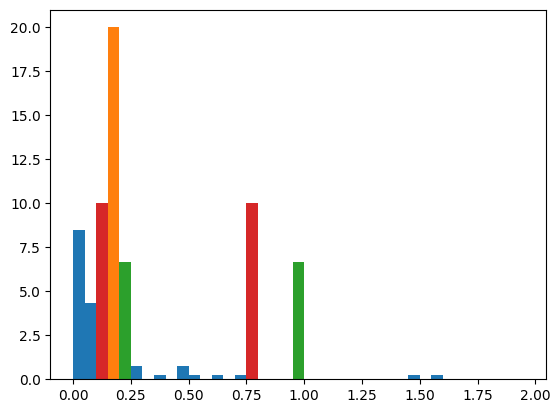

In [21]:
#FlpFlopRates['CHOL']
distFlipFlopRates = plt.hist(FlipFlopRates['CHOL'], density=True,bins=np.arange(0,2,0.05))
print(np.average(FlipFlopRates['CHOL']), np.average(APLS['CHOL']))
print(np.min(FlipFlopRates['CHOL']), np.max(FlipFlopRates['CHOL']), np.median(FlipFlopRates['CHOL']))
distFlipFlopRates = plt.hist(FlipFlopRates['DCHOL'], density=True,bins=np.arange(0,2,0.05))
print(np.average(FlipFlopRates['DCHOL']), np.average(APLS['DCHOL']))
distFlipFlopRates = plt.hist(FlipFlopRates['DOG'], density=True,bins=np.arange(0,2,0.05))
print(np.average(FlipFlopRates['DOG']), np.average(APLS['DOG']))
distFlipFlopRates = plt.hist(FlipFlopRates['SDG'], density=True,bins=np.arange(0,2,0.05))
print(np.average(FlipFlopRates['SDG']), np.average(APLS['SDG']))

In [22]:
for i in flipflops_dict:
    temperature = flipflops_dict[i]['TEMPERATURE']
    if temperature > 330 and 'CHOL' in flipflops_dict[i]:
    #if 'CHOL' in flipflops_dict[i] and flipflops_dict[i]['CHOL']['success'] > 1.0:
    #if 'CHOL' in flipflops_dict[i] and flipflops_dict[i]['avgOP'] < 0.1 and flipflops_dict[i]['avgOP'] > 0:
            print(flipflops_dict[i]['path'])
            print(flipflops_dict[i]['CHOL'])
            print(temperature)
            print(flipflops_dict[i]['avgOP'])
            !cat {flipflops_dict[i]['path'] + 'README.yaml'}
            print()


../Data/Flipflops/568/5fe/5685fec84c6595c5a4242b41a9e79ac6e67dfefb/41de202addf945cd61cfdf1537d775af00adc37b/
{'success': 0.06724045185583648, 'NumberOfSuccess': 7, 'failed': 0.0}
333.15
0.14575084068930014
DOI: 10.5281/zenodo.6943929
SOFTWARE: gromacs
TRJ:
- - CHOL13_medium.xtc
TPR:
- - CHOL13_medium.tpr
PREEQTIME: 0
TIMELEFTOUT: 0
COMPOSITION:
  DOPC:
    NAME: DOPC
    MAPPING: mappingDOPCcharmm.yaml
    COUNT:
    - 128
    - 128
  CHOL:
    NAME: CHL1
    MAPPING: mappingCHOLESTEROLcharmm.yaml
    COUNT:
    - 51
    - 53
  SOL:
    NAME: TIP3
    MAPPING: mappingTIP3PCHARMMgui.yaml
    COUNT: 18000
DIR_WRK: /home/lara/Databank
PUBLICATION: null
AUTHORS_CONTACT: Javanainen, Matti
SYSTEM: 256DOPC_104CHOL_18000SOL_333K
SOFTWARE_VERSION: null
FF: CHARMM36
FF_SOURCE: CHARMM-GUI
FF_DATE: null
CPT:
- - CHOL13_medium.cpt
LOG: null
TOP:
- - CHOL13_medium.top
GRO:
- - CHOL13_medium.gro
TRAJECTORY_SIZE: 357233792
TRJLENGTH: 1001000.0
TEMPERATURE: 333.15
NUMBER_OF_ATOMS: 97024
DATEOFRUNNING: 


../Data/Flipflops/9e6/063/9e60635b4cc2ab8156bafab587497006e5c27830/27e04320d664bc2bde5131c4d195fef3a29a1d3a/
{'success': 0.022299129441986587, 'NumberOfSuccess': 20, 'failed': 0.0}
333.15
0.18019820656346058
DOI: 10.5281/zenodo.6943929
SOFTWARE: gromacs
TRJ:
- - CHOL28_large.xtc
TPR:
- - CHOL28_large.tpr
PREEQTIME: 0
TIMELEFTOUT: 0
COMPOSITION:
  DOPC:
    NAME: DOPC
    MAPPING: mappingDOPCcharmm.yaml
    COUNT:
    - 512
    - 512
  CHOL:
    NAME: CHL1
    MAPPING: mappingCHOLESTEROLcharmm.yaml
    COUNT:
    - 450
    - 446
  SOL:
    NAME: TIP3
    MAPPING: mappingTIP3PCHARMMgui.yaml
    COUNT: 96000
DIR_WRK: /home/lara/Databank
PUBLICATION: null
AUTHORS_CONTACT: Javanainen, Matti
SYSTEM: 1024DOPC_896CHOL_96000SOL_333K
SOFTWARE_VERSION: null
FF: CHARMM36
FF_SOURCE: CHARMM-GUI
FF_DATE: null
CPT:
- - CHOL28_large.cpt
LOG: null
TOP:
- - CHOL28_large.top
GRO:
- - CHOL28_large.gro
TRAJECTORY_SIZE: 1868712904
TRJLENGTH: 1001000.0
TEMPERATURE: 333.15
NUMBER_OF_ATOMS: 495616
DATEOFRUNNIN

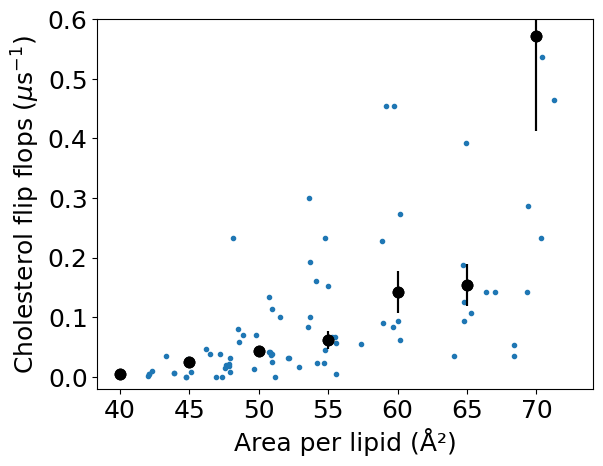

In [23]:
tmp = {}
for i in flipflops_dict:
    if 'CHOL' in flipflops_dict[i]:
        tmp[i] = flipflops_dict[i]
    
plotCorrelation('APL','CHOL',tmp)
result = plotXaveragedData('APL','CHOL',tmp,5,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.6])
plt.savefig('../figures/CHOLflipflopVSapl.pdf',bbox_inches='tight')
plt.show()

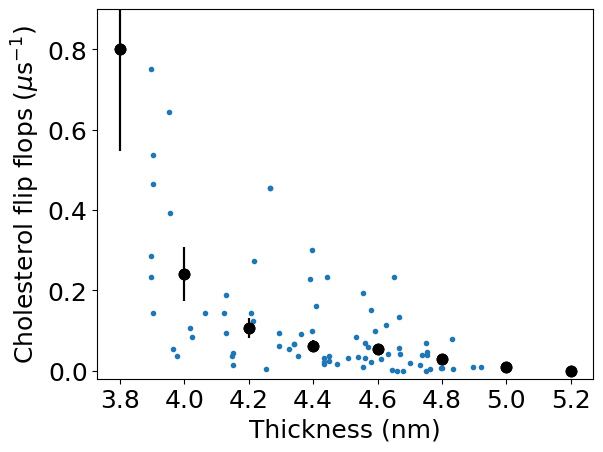

In [24]:
plotCorrelation('thickness','CHOL',tmp)
result = plotXaveragedData('thickness','CHOL',tmp,0.2,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Thickness (nm)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.9])
plt.savefig('../figures/CHOLflipflopVSthickness.pdf',bbox_inches='tight')
plt.show()

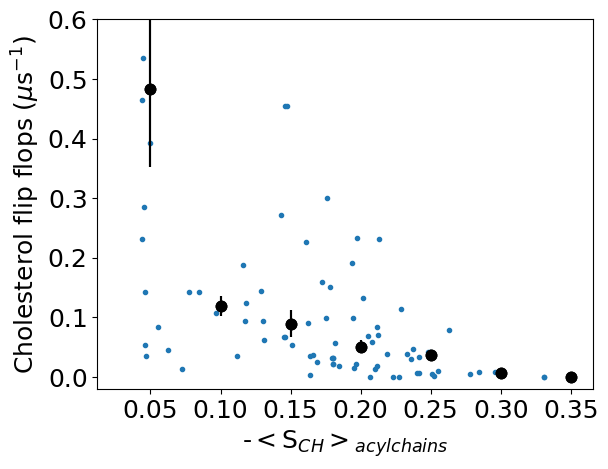

In [25]:
plotCorrelation('avgOP','CHOL',tmp)
result = plotXaveragedData('avgOP','CHOL',tmp,0.05,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('-$<$S$_{CH}>_{acyl chains}$', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.6])
plt.savefig('../figures/CHOLflipflopVSorder.pdf',bbox_inches='tight')
plt.show()

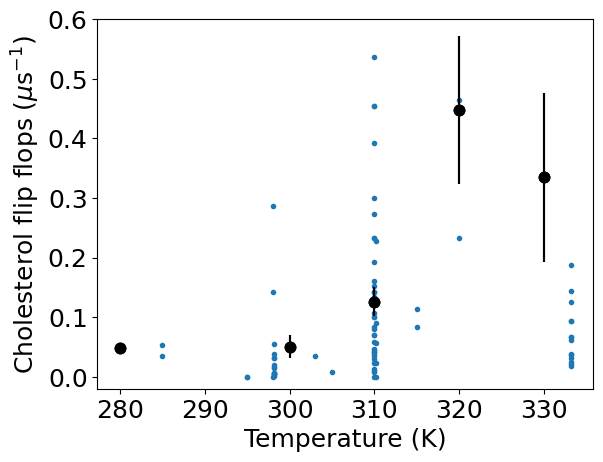

In [26]:
plotCorrelation('TEMPERATURE','CHOL',tmp)
result = plotXaveragedData('TEMPERATURE','CHOL',tmp,10,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Temperature (K)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.6])
#plt.savefig('../figures/APLvsPERMEATION.pdf')
plt.show()

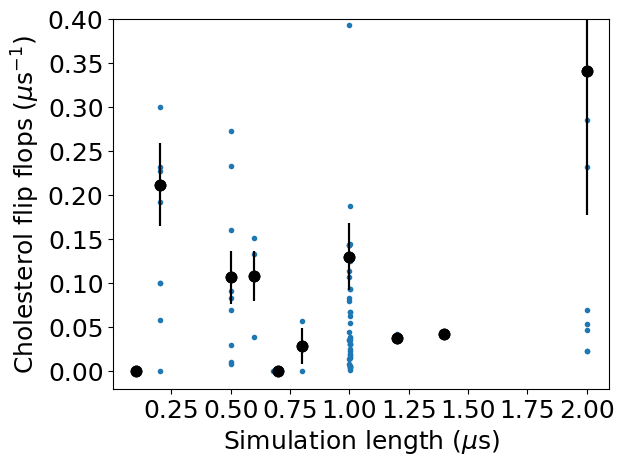

In [27]:
plotCorrelation('SimLength','CHOL',tmp)
result = plotXaveragedData('SimLength','CHOL',tmp,0.1,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Simulation length ($\mu$s)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.4])
#plt.savefig('../figures/APLvsPERMEATION.pdf')
plt.show()

In [84]:
n_systems = len(systems)
#print(len(systems))
n_flipflops_sytems = np.zeros((n_systems,7), dtype=np.float64)
j = 0
flipflops_dict = {}
for i, system in enumerate(systems):
    if 'WARNINGS' in system and 'ORIENTATION' in system['WARNINGS'] and system['WARNINGS']['ORIENTATION'] == 'x-normal':
        continue
    if system['SOFTWARE'] == 'openMM':
        continue
        
    path = system['path']
    n_flipflops_sytems[i][2] = system['TEMPERATURE']
    time = system['TRJLENGTH']/1000000
    #n_flipflops_sytems[i][3] = time#*1000000/system['TRAJECTORY_SIZE']
    #print(n_flipflops_sytems[i][3])
    n_flipflops_sytems[i][4] = CalcAreaPerMolecule(system)
    
    try:
        n_flipflops_sytems[i][5] = GetThickness(system)
    except:
        n_flipflops_sytems[i][5] = 0
    try:
        n_flipflops_sytems[i][6] = -np.average(averageOrderParameters(system))
    except:
        n_flipflops_sytems[i][6] = 0
    
    flipflops, names, list_names = getFlipflop(path)
    
    #print(list_names, path)
    
    if names != []:
        #print(list_names, path)
        mask = list(np.not_equal(flipflops[:,-1],0))
        names_masked = list(compress(names, mask))
        list_names = list(set(names_masked))
        if len(list_names) == 1:
            count = sum(system['COMPOSITION'][list_names[0]]['COUNT'])
            n_flipflops_sytems[i][0] = np.count_nonzero(flipflops[:,-1] == 1)/time/count
            n_flipflops_sytems[i][1] = np.count_nonzero(flipflops[:,-1] == 0)/time/count
            n_flipflops_sytems[i][3] = np.sort(flipflops[:,1])[0]


            if list_names[0] in flipflops_dict:
                flipflops_dict[list_names[0]] = np.append(flipflops_dict[list_names[0]], n_flipflops_sytems[i])

            else:
                flipflops_dict[list_names[0]] = np.array(n_flipflops_sytems[i])
        elif len(list_names) == 0:
            count = 1
        else:
            print('more then 1 lipid flipfloped... tba')
        j +=1
for name in flipflops_dict.keys():
    flipflops_dict[name] = np.reshape(flipflops_dict[name],(-1,7))
    #print(flipflops_dict[name])
    
#print(flipflops_dict)
    
#print(n_flipflops_sytems[:,3])
print(j)
#print(n_flipflops_sytems)



no file
no file
130


[]

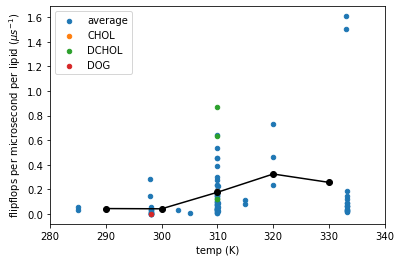

In [85]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

avg_flipflops, bined_T, foo = stats.binned_statistic(
                             flipflips_masked[:,2], 
                             flipflips_masked[:,0], 
                             statistic='mean', 
                             bins=6, 
                             range=(275, 335))
avg_flipflops = np.nan_to_num(avg_flipflops)
mask = np.not_equal(avg_flipflops, 0)

avg_flipflops = avg_flipflops[mask] 
bined_T = bined_T[:-1][mask] + 5

names = list(flipflops_dict.keys())
names.sort()
for name in names:
    plt.scatter(flipflops_dict[name][:,2], flipflops_dict[name][:,0], s = 20)
plt.scatter(bined_T, avg_flipflops, c = 'k')
plt.plot(bined_T, avg_flipflops, c = 'k')
plt.legend(['average','CHOL','DCHOL','DOG'])
plt.xlim(280, 340)
plt.xlabel('temp (K)')
plt.ylabel('flipflops per microsecond per lipid ($\mu$$s^{-1}$)')
plt.plot()

 
-5.327 x + 15.13


[]

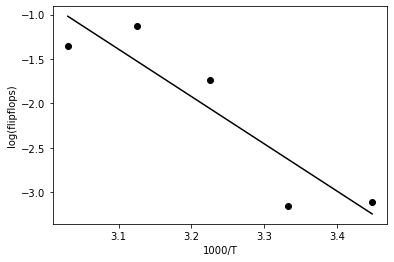

In [9]:
inv_T = 1000/bined_T
fliplops_loged = np.log(avg_flipflops)

polynome = np.polyfit(inv_T, fliplops_loged, 1)
p = np.poly1d(polynome)
print(p)

plt.scatter(inv_T, fliplops_loged, c = 'k')
plt.plot(inv_T, p(inv_T), c = 'k')
#plt.ylim(-1, 50)
plt.xlabel('1000/T')
plt.ylabel('log(flipflops)')
plt.plot()

['CHOL', 'DCHOL', 'DOG', 'POPC']


[]

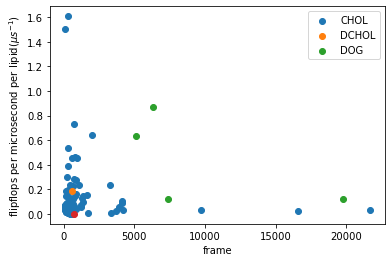

In [10]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflops_masked = n_flipflops_sytems[mask]


#plt.scatter(flipflops_masked[:,3], flipflops_masked[:,0])
names = list(flipflops_dict.keys())
names.sort()
print(names)
for name in names:
    plt.scatter(flipflops_dict[name][:,3], flipflops_dict[name][:,0])
plt.legend(['CHOL','DCHOL','DOG'])
#plt.xlim(-1, 50)
plt.xlabel('frame')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()



(0.5509454923998125, 0.00012893554134368518)


[]

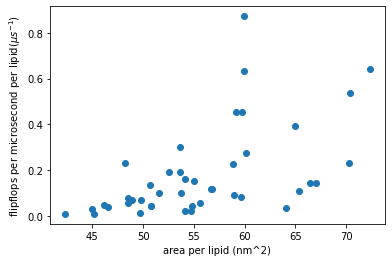

In [11]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]



#checking system with temp ~310K
mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,4], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,4], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('area per lipid (nm^2)')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

(-0.38285904983182234, 0.011278018078506076)


[]

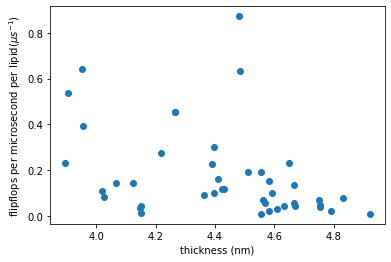

In [12]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

#checking system with temp ~310K
mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,5], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,5], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('thickness (nm)')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

(0.21461740258030998, 0.05137037607549313)


[]

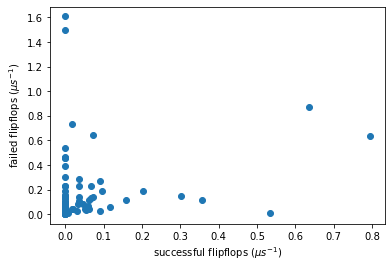

In [13]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

print(stats.pearsonr(flipflips_masked[:,1], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,1], flipflips_masked[:,0])
#lt.xlim(0, 1.7)
plt.xlabel('successful flipflops ($\mu$$s^{-1}$)')
plt.ylabel('failed flipflops ($\mu$$s^{-1}$)')
plt.plot()

(-0.5544566635380086, 0.00011434072295098495)


[]

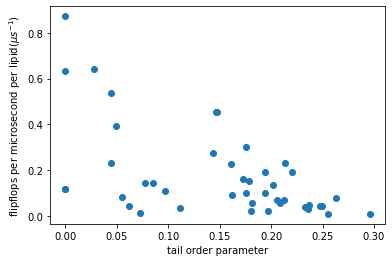

In [14]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

#checking system with temp ~310K

mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,6], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,6], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('tail order parameter')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

In [34]:
for system in systems:
    path = system['path']
    #print(path)
    temperature = system['TEMPERATURE']
    if temperature > 330:
        
        flipflops, names, list_names = getFlipflop(path)
        #time = system['TRJLENGTH']/1000000
        #count = sum(system['COMPOSITION'][list_names[0]]['COUNT'])
        #np.count_nonzero(flipflops[:,-1] == 1)/time/count
        
        
        
        if len(flipflops) > 0:
            #print(np.count_nonzero(flipflops[:,-1] == 1))
            #print(system)
        #print(list_names)
            #if 'POPC' in list_names:
            print(flipflops, names, list_names)
            print(path)

            

[[ 80 744 749   1   1]] ['CHOL'] ['CHOL']
../Data/Flipflops/ca9/5ea/ca95eaec9e05d0b4ef1d99e1c4577f0e4cec455c/3abfac8381036ab1ab6d06199cf5cc480c1963b0/
[[ 69 670 673   1   1]] ['CHOL'] ['CHOL']
../Data/Flipflops/dec/cb5/deccb577ca8ad6e421736887bee86a9205242916/40169c0c0397357618cdad94ea374018fe4bc318/
[[1049  374  381    1    1]
 [1067  788  793    1    1]
 [1073  301  304    1    1]
 [1127  165  169    1    1]
 [1129  880  887   -1    1]
 [1162  547  552   -1    1]
 [1169  246  251    1    1]
 [1222  664  672    1    1]
 [1232  563  570    1    1]
 [1233  759  763   -1    1]
 [1254  847  851    1    1]
 [1257  117  121    1    1]
 [1270  551  555   -1    1]
 [1281  586  591    1    1]
 [1285  323  327   -1    1]
 [1286  301  304   -1    1]
 [1297  608  613   -1    1]
 [1304  264  267    1    1]
 [1304  421  425   -1    1]
 [1316  442  448   -1    1]
 [1333  534  555    1    1]
 [1338  671  674   -1    1]
 [1358  334  337    1    1]
 [1382  322  324    1    1]
 [1397  822  829   -1    1

In [35]:
n_flipflops_sytems

array([[0.00000000e+00, 0.00000000e+00, 3.03000000e+02, ...,
        5.48160002e+01, 4.53331986e+00, 2.23307893e-01],
       [9.08909127e-02, 0.00000000e+00, 3.10150000e+02, ...,
        5.89123097e+01, 4.36200128e+00, 1.62091906e-01],
       [0.00000000e+00, 0.00000000e+00, 3.10000000e+02, ...,
        6.49671402e+01, 4.12439278e+00, 1.28372804e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.10150000e+02, ...,
        5.81211126e+01, 4.73922574e+00, 1.78436266e-01],
       [0.00000000e+00, 0.00000000e+00, 2.98000000e+02, ...,
        6.19764423e+01, 4.36055420e+00, 1.58670782e-01],
       [0.00000000e+00, 0.00000000e+00, 3.20000000e+02, ...,
        6.49860033e+01, 4.25687750e+00, 1.40405030e-01]])

In [42]:
for i in flipflops_dict['CHOL']:
    print(i[0],i[2])
    

0.0908909127265456 310.15
0.08331666999933347 315.0
0.3928178610710358 310.0
0.01921155767309614 298.15
0.029844777313194078 310.0
0.022726136420451702 310.15
0.14284285857128573 310.0
0.046509302441854646 310.0
0.2321312505803281 310.0
0.45431829539775564 310.0
0.29985007496251875 310.0
0.004459825888397317 298.15
0.031218781218781223 298.15
0.05681108043312768 310.15
0.10713214392846429 310.0
0.003902347652347653 298.15
0.058110479643898975 310.0
0.15996800639872025 310.0
0.07953750079537501 310.0
0.04463839330352679 310.0
0.06243756243756245 333.15
0.46423929035667866 320.0
0.1248751248751249 333.15
0.03571071464282143 285.0
0.11362500113625001 315.0
0.06724045185583648 333.15
0.2324419185755959 310.0
0.14284285857128573 310.0
0.009998000399920015 310.0
0.1922115865144351 310.0
0.037462537462537464 333.15
1.4998500149985001 333.0
0.01783930355358927 333.15
0.09995002498750624 310.0
0.006243756243756245 298.15
0.06999650017499125 310.0
0.08332500083325001 310.0
0.45431829539775564 31

In [43]:
tst = []
tst[0] =1

IndexError: list assignment index out of range

In [58]:
maxrates = {}
for Lipid in lipids_dict:
    LipidTime = 0
    #Lipid = 'DPPC'
    for system in systems:
        #print(system['TRJLENGTH'])
        if Lipid in system['COMPOSITION']:
            #print(system)
            length = np.sum(system['COMPOSITION'][Lipid]['COUNT'])
            Nlipid = system['TRJLENGTH']*10**(-6) #us
            LipidTime += Nlipid*length
    print(Lipid, LipidTime)
    maxrates[Lipid] = LipidTime
    
HGmaxrates = {'PC': 0, 'PE': 0, 'PG': 0, 'PS':0, 'PI':0, 'CER':0}
for Lipid in maxrates:
    for HG in HGmaxrates:
        if HG in Lipid:
            HGmaxrates[HG] += maxrates[Lipid]
        
print()
print(HGmaxrates)

POPC 65611.42748801471
POPG 2478.057860000001
POPS 1343.9730240000001
POPE 2022.9757799999995
PYPC 1345.3439999999998
PAzePCprot 1.9007599999999998
PAzePCdeprot 2.28076
DMPC 1730.9748
DPPC 16269.217663908203
DPPE 116.80704
DPPG 28.811519999999998
DEPC 100.02
DRPC 1345.3439999999998
DYPC 1345.344
DLPC 140.341008
DLIPC 1730.3825000000002
DOG 74.40096
DOPC 10489.204599999997
DOPE 256.032
DDOPC 375.0375
DOPS 168.08255999999997
DSPC 583.6288
DAPC 4776.347599999999
DMTAP 0
SDG 74.40096
SDPE 635.2076
SOPC 2690.688
POPI 32.001599999999996
SAPI 92.00459999999998
SLPI 28.001399999999997
CER 613.8532
CHOL 20067.45927999999
DCHOL 84.012
DHMDMAB 119.96766
SLiPC 1345.3439999999998

{'PC': 109882.82747992291, 'PE': 3031.0224199999993, 'PG': 2506.869380000001, 'PS': 1512.0555840000002, 'PI': 152.00759999999997, 'CER': 613.8532}
